## PROJECT : SALARY PREDİCTİON WİTH MACHİNE LEARNİNG

    Maaş bilgileri ve 1986 yılına ait kariyer istatistikleri paylaşılan
    beyzbol oyuncularının maaş tahminleri için bir makine öğrenmesi modeli geliştirilebilir mi?

### GEREKLİ KÜTÜPHANE VE FONKSİYONLAR

In [2]:
import numpy as np
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate,validation_curve

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 750)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

### GELİŞMİŞ FONKSİYONEL KEŞİFCİ VERİ ANALİZİ (ADVANCED FUNCTİONAL EDA)

    1. Genel Resim.
    2. Kategorik Değişken Analizi (Analysis of Categorical veriables)
    3. Sayısal Veri Analizi (Analysis of Numerical Veriables)
    4. Hedef Değişken Analizi (Analysis of Target Veriables)
    5. Korelasyon Analizi (Analysis of Corelation)

#### 1. Genel Resim

In [11]:
df = pd.read_csv(f"C:/Users/duran/PycharmProjects/Hitters_Salary_Prediction/datasets/hitters.csv")

def check_df(dataframe, head=5):
    print("################ SHAPE #################")
    print(dataframe.shape)

    print("################ TYPES #################")
    print(dataframe.dtypes)

    print("################ HEAD #################")
    print(dataframe.head(head))

    print("################ TAİL #################")
    print(dataframe.tail(head))

    print("################ NA #################")
    print(dataframe.isnull().sum())

    print("################ QUANTİLES #################")
    print(dataframe.describe([0,0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)




################ SHAPE #################
(322, 20)
################ TYPES #################
AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object
################ HEAD #################
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague
0    293    66      1    30   29     14      1     293     66       1     30    29      14      A        E      446       33      20     NaN         A
1    315    81      7    24   38     39     14    3449    835      69    321   414     375      N        W      632       43      10

Skewness: 1.59
Mean: 535.93
Median: 425.00
Standard Deviation: 451.12
Minimum: 67.50
Maximum: 2460.00
Shapiro-Wilk Test p-value: 0.0000


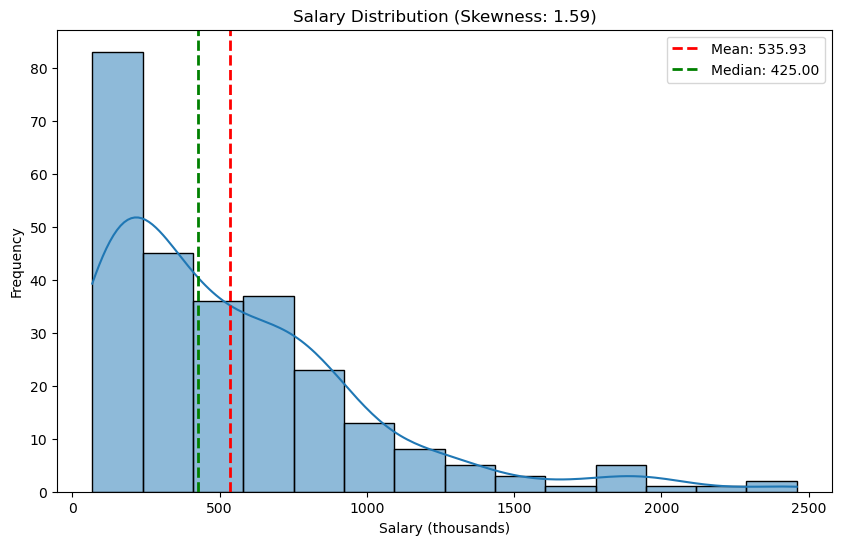

In [12]:
from scipy import stats

def show_salary_skewness(df):
    # Salary sütunundaki eksik değerleri kaldırma
    salary = df['Salary'].dropna()

    # Çarpıklık değerini hesaplama
    skewness = salary.skew()

    # Histogram ve yoğunluk grafiği çizme
    plt.figure(figsize=(10, 6))
    sns.histplot(salary, kde=True)
    plt.title(f'Salary Distribution (Skewness: {skewness:.2f})')
    plt.xlabel('Salary (thousands)')
    plt.ylabel('Frequency')

    # Ortalama ve medyanı gösterme
    plt.axvline(salary.mean(), color='r', linestyle='dashed', linewidth=2, label=f'Mean: {salary.mean():.2f}')
    plt.axvline(salary.median(), color='g', linestyle='dashed', linewidth=2, label=f'Median: {salary.median():.2f}')
    plt.legend()

    # İstatistiksel bilgileri yazdırma
    print(f"Skewness: {skewness:.2f}")
    print(f"Mean: {salary.mean():.2f}")
    print(f"Median: {salary.median():.2f}")
    print(f"Standard Deviation: {salary.std():.2f}")
    print(f"Minimum: {salary.min():.2f}")
    print(f"Maximum: {salary.max():.2f}")

    # Shapiro-Wilk normallik testi
    _, p_value = stats.shapiro(salary)
    print(f"Shapiro-Wilk Test p-value: {p_value:.4f}")

    plt.show()


show_salary_skewness(df)

In [13]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Veri setindeki kategorik, sayısal ve kategorik gibi davranan ama sayısal olmayan değişkenleri ayırır.

    """

    # Kategorik değişkenleri seçme
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # Sayısal değişkenleri seçme
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # Sonuçları yazdırma
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")

    return cat_cols, num_cols, cat_but_car


# Kullanım örneği:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


#### 2. Kategorik Değişken Analizi (Analysis of Categorical veriables)

        League  Ratio
League               
A          175 54.348
N          147 45.652
#############################################


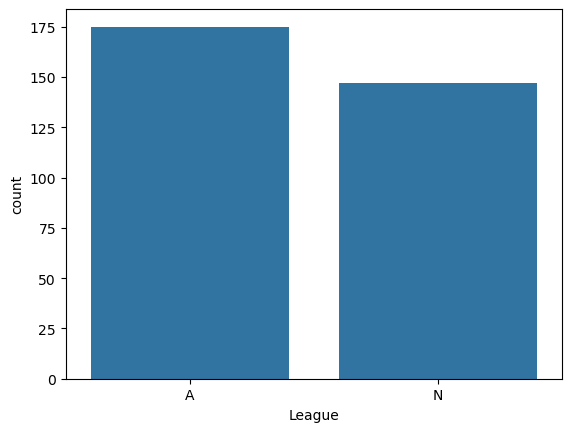

          Division  Ratio
Division                 
W              165 51.242
E              157 48.758
#############################################


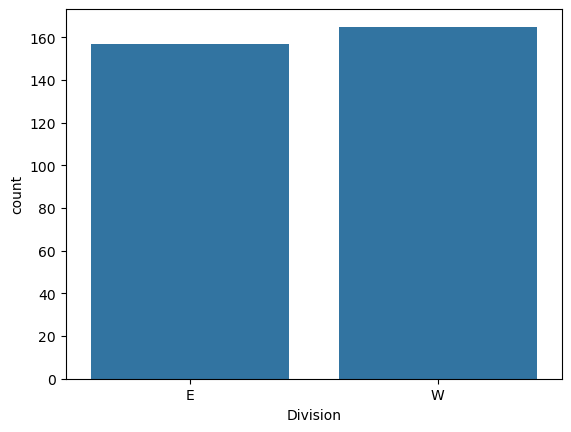

           NewLeague  Ratio
NewLeague                  
A                176 54.658
N                146 45.342
#############################################


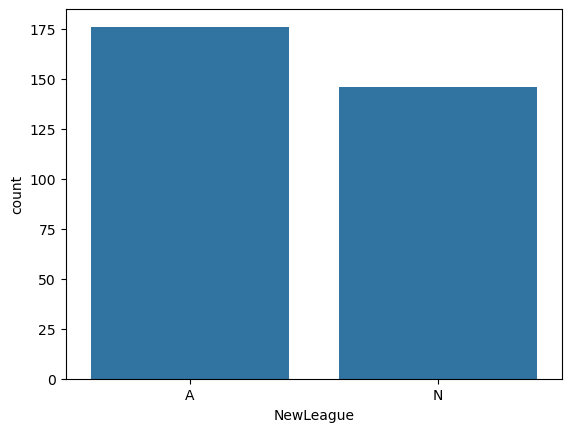

In [6]:
def cat_sumary(dataframe, col_name, plot = False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100* dataframe[col_name].value_counts()/ len(dataframe)}))

    print('#############################################')

    if plot:
        sns.countplot(x = dataframe[col_name], data = dataframe)
        plt.show(block= True)

for col in cat_cols:
    cat_sumary(df, col, plot = True)

#### 3. Sayısal Veri Analizi (Analysis of Numerical Veriables)

count   322.000
mean    380.929
std     153.405
min      16.000
5%      161.000
10%     194.100
20%     221.800
30%     281.300
40%     321.800
50%     379.500
60%     430.200
70%     490.000
80%     535.600
90%     584.900
95%     609.900
99%     658.590
max     687.000
Name: AtBat, dtype: float64


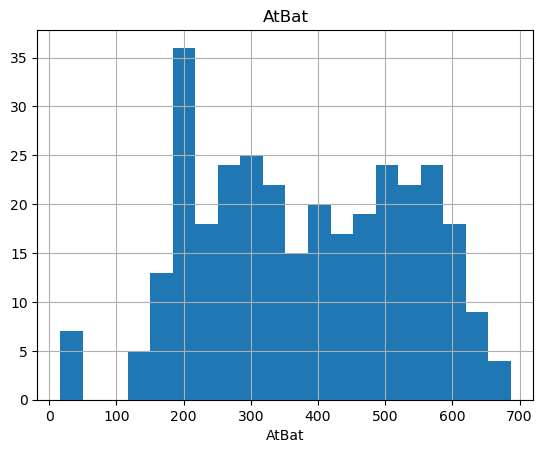

count   322.000
mean    101.025
std      46.455
min       1.000
5%       39.000
10%      45.100
20%      57.000
30%      70.000
40%      82.000
50%      96.000
60%     113.000
70%     128.700
80%     144.000
90%     163.000
95%     174.000
99%     210.790
max     238.000
Name: Hits, dtype: float64


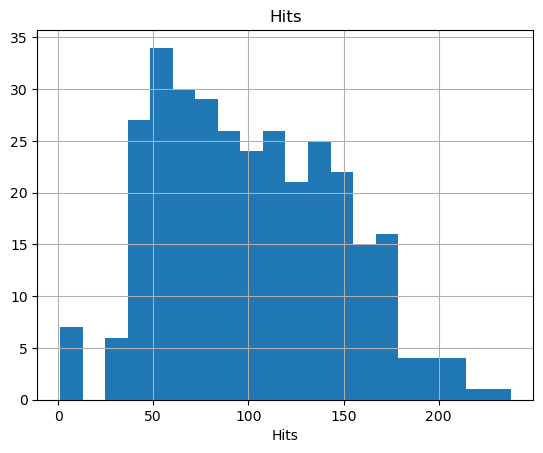

count   322.000
mean     10.770
std       8.709
min       0.000
5%        0.000
10%       1.000
20%       3.000
30%       5.000
40%       6.000
50%       8.000
60%      10.600
70%      14.000
80%      18.000
90%      24.000
95%      28.950
99%      33.000
max      40.000
Name: HmRun, dtype: float64


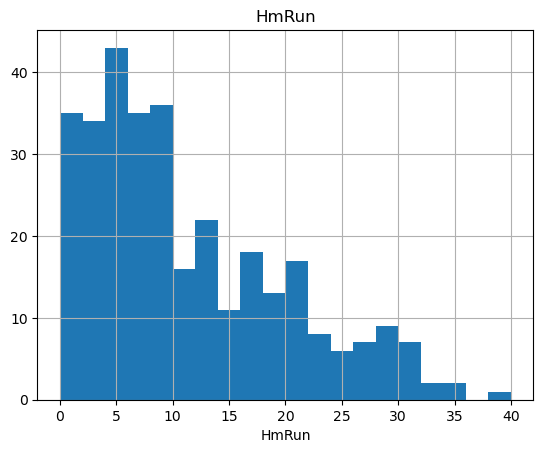

count   322.000
mean     50.910
std      26.024
min       0.000
5%       17.000
10%      20.100
20%      27.000
30%      33.000
40%      41.000
50%      48.000
60%      55.600
70%      66.000
80%      75.800
90%      89.000
95%      94.000
99%     107.790
max     130.000
Name: Runs, dtype: float64


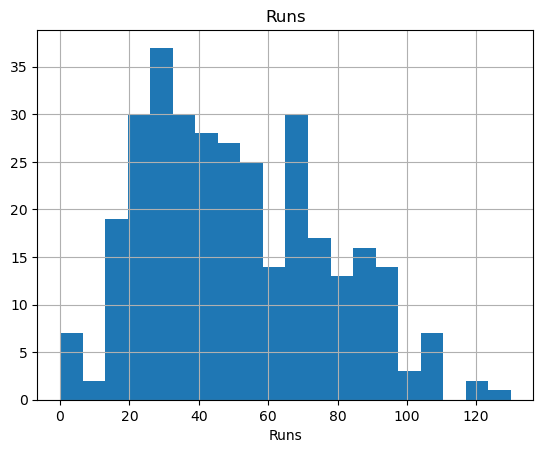

count   322.000
mean     48.028
std      26.167
min       0.000
5%       14.000
10%      19.000
20%      26.000
30%      30.000
40%      36.400
50%      44.000
60%      49.000
70%      58.000
80%      73.000
90%      86.000
95%      96.000
99%     112.370
max     121.000
Name: RBI, dtype: float64


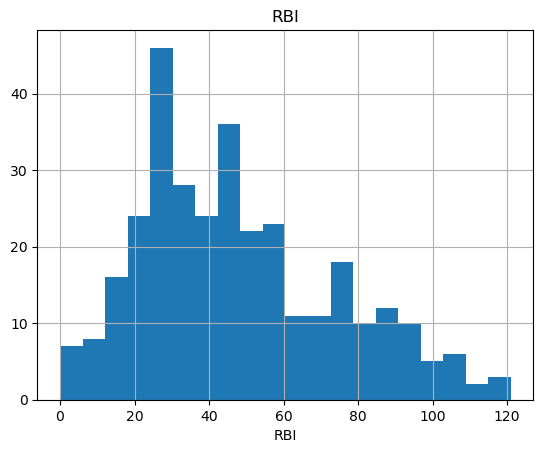

count   322.000
mean     38.742
std      21.639
min       0.000
5%       11.050
10%      15.000
20%      20.000
30%      24.000
40%      30.000
50%      35.000
60%      40.000
70%      48.700
80%      59.000
90%      69.900
95%      78.000
99%      93.580
max     105.000
Name: Walks, dtype: float64


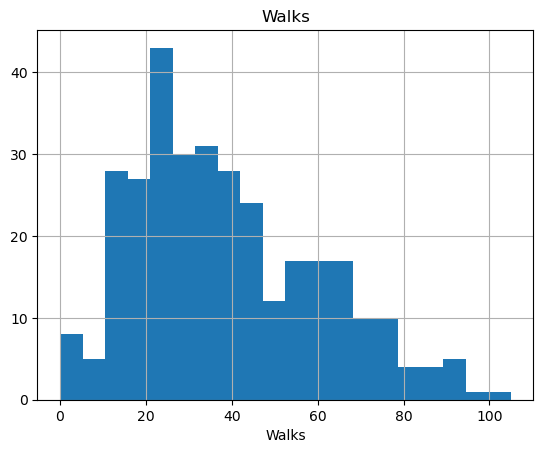

count   322.000
mean      7.444
std       4.926
min       1.000
5%        1.000
10%       2.000
20%       3.000
30%       4.000
40%       5.000
50%       6.000
60%       7.600
70%      10.000
80%      12.000
90%      15.000
95%      17.000
99%      19.790
max      24.000
Name: Years, dtype: float64


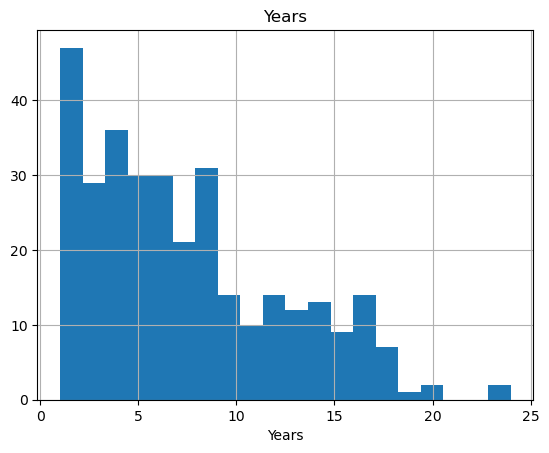

count     322.000
mean     2648.683
std      2324.206
min        19.000
5%        216.500
10%       342.200
20%       667.600
30%       963.400
40%      1402.200
50%      1928.000
60%      2654.000
70%      3365.000
80%      4483.000
90%      6123.400
95%      7125.600
99%      8749.970
max     14053.000
Name: CAtBat, dtype: float64


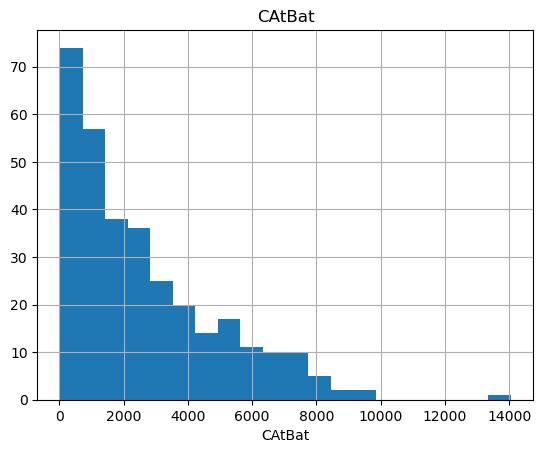

count    322.000
mean     717.571
std      654.473
min        4.000
5%        54.000
10%       86.000
20%      164.600
30%      238.000
40%      355.800
50%      508.000
60%      708.200
70%      911.100
80%     1229.200
90%     1659.600
95%     2017.150
99%     2500.340
max     4256.000
Name: CHits, dtype: float64


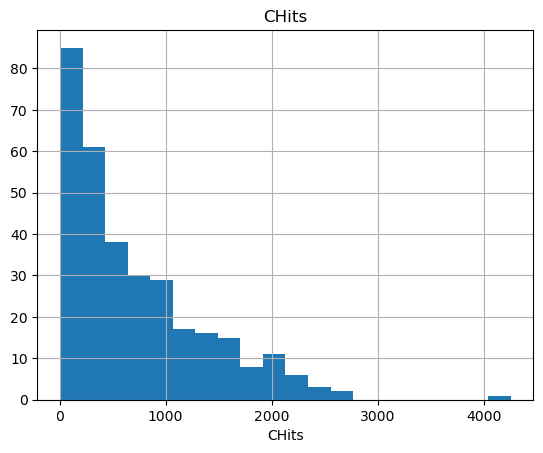

count   322.000
mean     69.491
std      86.266
min       0.000
5%        2.000
10%       4.000
20%      10.200
30%      16.300
40%      27.400
50%      37.500
60%      51.200
70%      72.400
80%     103.800
90%     194.900
95%     265.650
99%     373.120
max     548.000
Name: CHmRun, dtype: float64


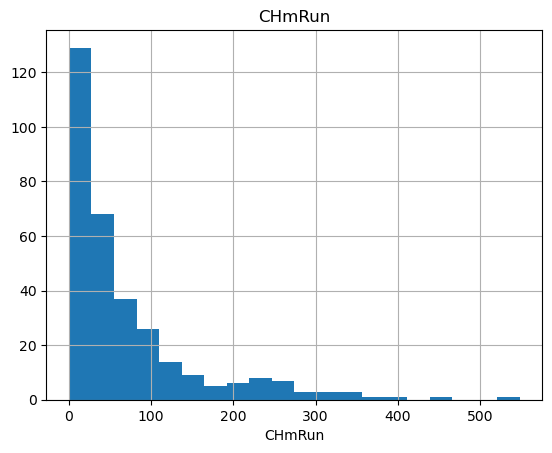

count    322.000
mean     358.795
std      334.106
min        1.000
5%        27.000
10%       38.100
20%       80.400
30%      117.300
40%      181.000
50%      247.000
60%      333.000
70%      443.400
80%      627.200
90%      895.700
95%     1032.300
99%     1174.370
max     2165.000
Name: CRuns, dtype: float64


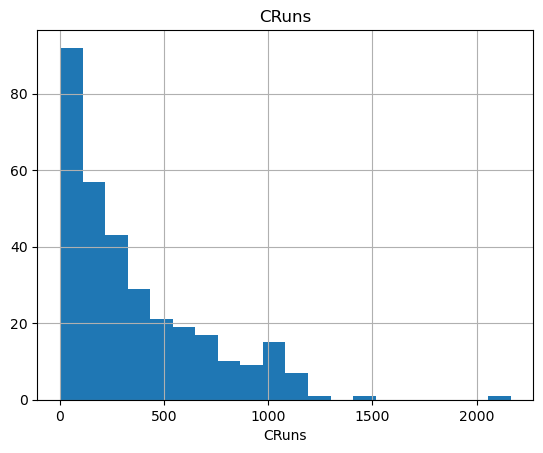

count    322.000
mean     330.118
std      333.220
min        0.000
5%        22.050
10%       34.100
20%       70.200
30%      106.300
40%      149.000
50%      220.500
60%      303.600
70%      379.100
80%      496.200
90%      861.600
95%     1071.750
99%     1310.850
max     1659.000
Name: CRBI, dtype: float64


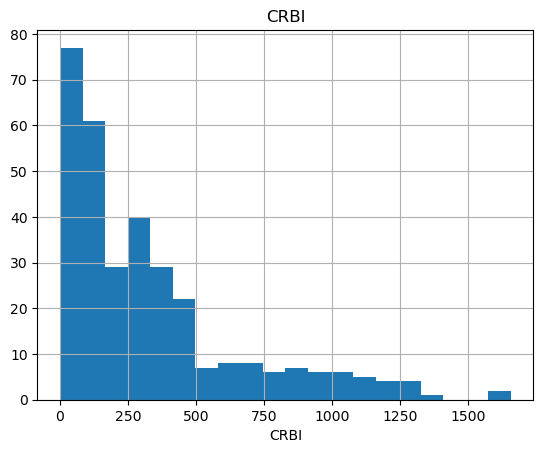

count    322.000
mean     260.239
std      267.058
min        0.000
5%        15.050
10%       30.100
20%       55.000
30%       82.000
40%      117.400
50%      170.500
60%      226.600
70%      300.700
80%      421.000
90%      643.900
95%      817.600
99%     1139.140
max     1566.000
Name: CWalks, dtype: float64


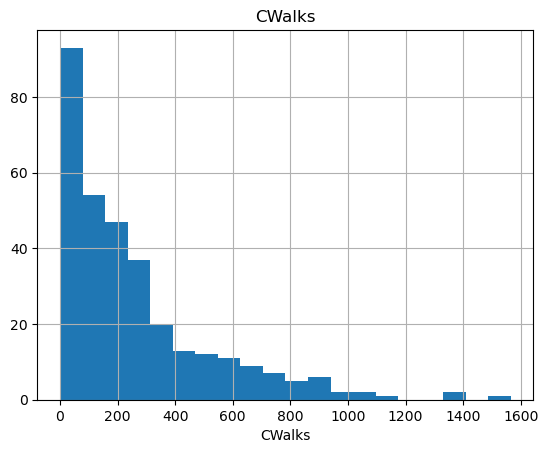

count    322.000
mean     288.938
std      280.705
min        0.000
5%        33.200
10%       62.200
20%       99.600
30%      132.000
40%      167.000
50%      212.000
60%      257.400
70%      303.000
80%      365.800
90%      685.600
95%      910.650
99%     1301.190
max     1378.000
Name: PutOuts, dtype: float64


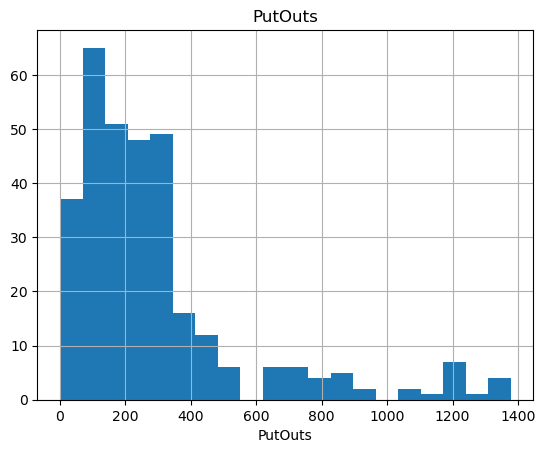

count   322.000
mean    106.913
std     136.855
min       0.000
5%        0.000
10%       2.000
20%       5.200
30%       9.000
40%      15.400
50%      39.500
60%      76.800
70%     134.800
80%     210.800
90%     353.300
95%     431.450
99%     478.160
max     492.000
Name: Assists, dtype: float64


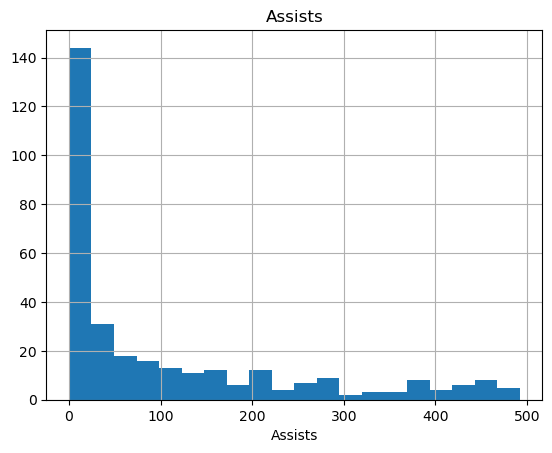

count   322.000
mean      8.040
std       6.368
min       0.000
5%        0.000
10%       1.000
20%       3.000
30%       4.000
40%       5.000
50%       6.000
60%       8.000
70%      10.000
80%      13.000
90%      17.000
95%      20.000
99%      25.790
max      32.000
Name: Errors, dtype: float64


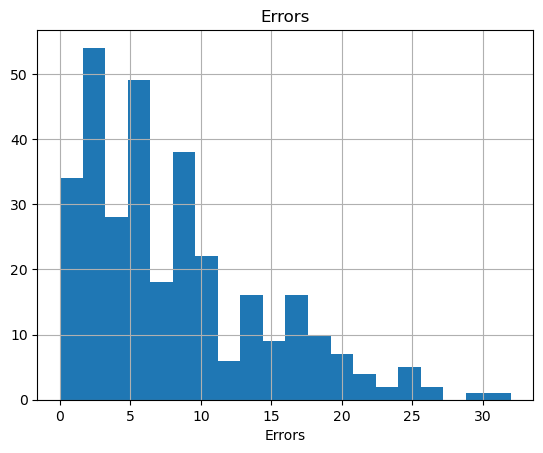

count    263.000
mean     535.926
std      451.119
min       67.500
5%        86.600
10%      100.000
20%      155.000
30%      221.000
40%      300.000
50%      425.000
60%      538.000
70%      700.000
80%      809.000
90%     1048.667
95%     1346.000
99%     2032.887
max     2460.000
Name: Salary, dtype: float64


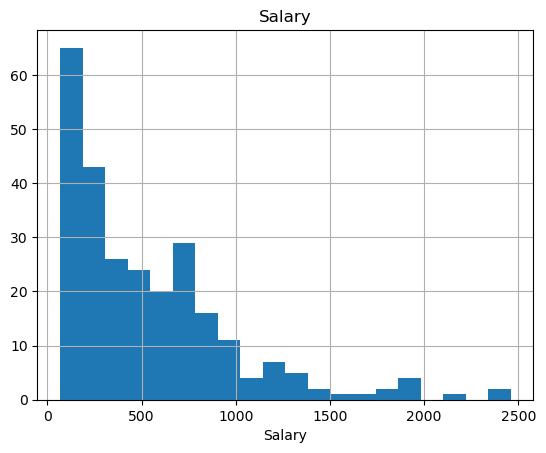

In [7]:
def num_sumary(dataframe, numerical_col, plot = False):

    quantiless = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95,0.99]

    print(dataframe[numerical_col].describe(quantiless).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block= True)


for col in num_cols:
    num_sumary(df, col, plot = True)

#### 4. Hedef Değişken Analizi (Analysis of Target Veriables)

In [8]:
def target_summary(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}),end= "\n\n\n")
    
for col in cat_cols:
    target_summary(df,"Salary", col)
    

        TARGET_MEAN
League             
A           542.000
N           529.118


          TARGET_MEAN
Division             
E             624.271
W             450.877


           TARGET_MEAN
NewLeague             
A              537.113
N              534.554




#### 5. Korelasyon Analizi (Analysis of Corelation)

         AtBat  Hits  HmRun  Runs   RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns   CRBI  CWalks  PutOuts  Assists  Errors  Salary
AtBat    1.000 0.975  0.575 0.926 0.841  0.703  0.088   0.353  0.370   0.357  0.391  0.376   0.316    0.371    0.280   0.367   0.446
Hits     0.975 1.000  0.567 0.932 0.845  0.693  0.110   0.369  0.394   0.365  0.410  0.395   0.333    0.344    0.255   0.333   0.479
HmRun    0.575 0.567  1.000 0.627 0.817  0.503  0.178   0.317  0.324   0.673  0.354  0.457   0.332    0.212   -0.113   0.041   0.367
Runs     0.926 0.932  0.627 1.000 0.821  0.757  0.068   0.321  0.342   0.366  0.388  0.352   0.330    0.307    0.170   0.282   0.441
RBI      0.841 0.845  0.817 0.821 1.000  0.674  0.191   0.400  0.414   0.582  0.433  0.508   0.392    0.298    0.103   0.224   0.474
Walks    0.703 0.693  0.503 0.757 0.674  1.000  0.176   0.366  0.373   0.423  0.414  0.411   0.512    0.306    0.128   0.180   0.440
Years    0.088 0.110  0.178 0.068 0.191  0.176  1.000   0.909  0.900 

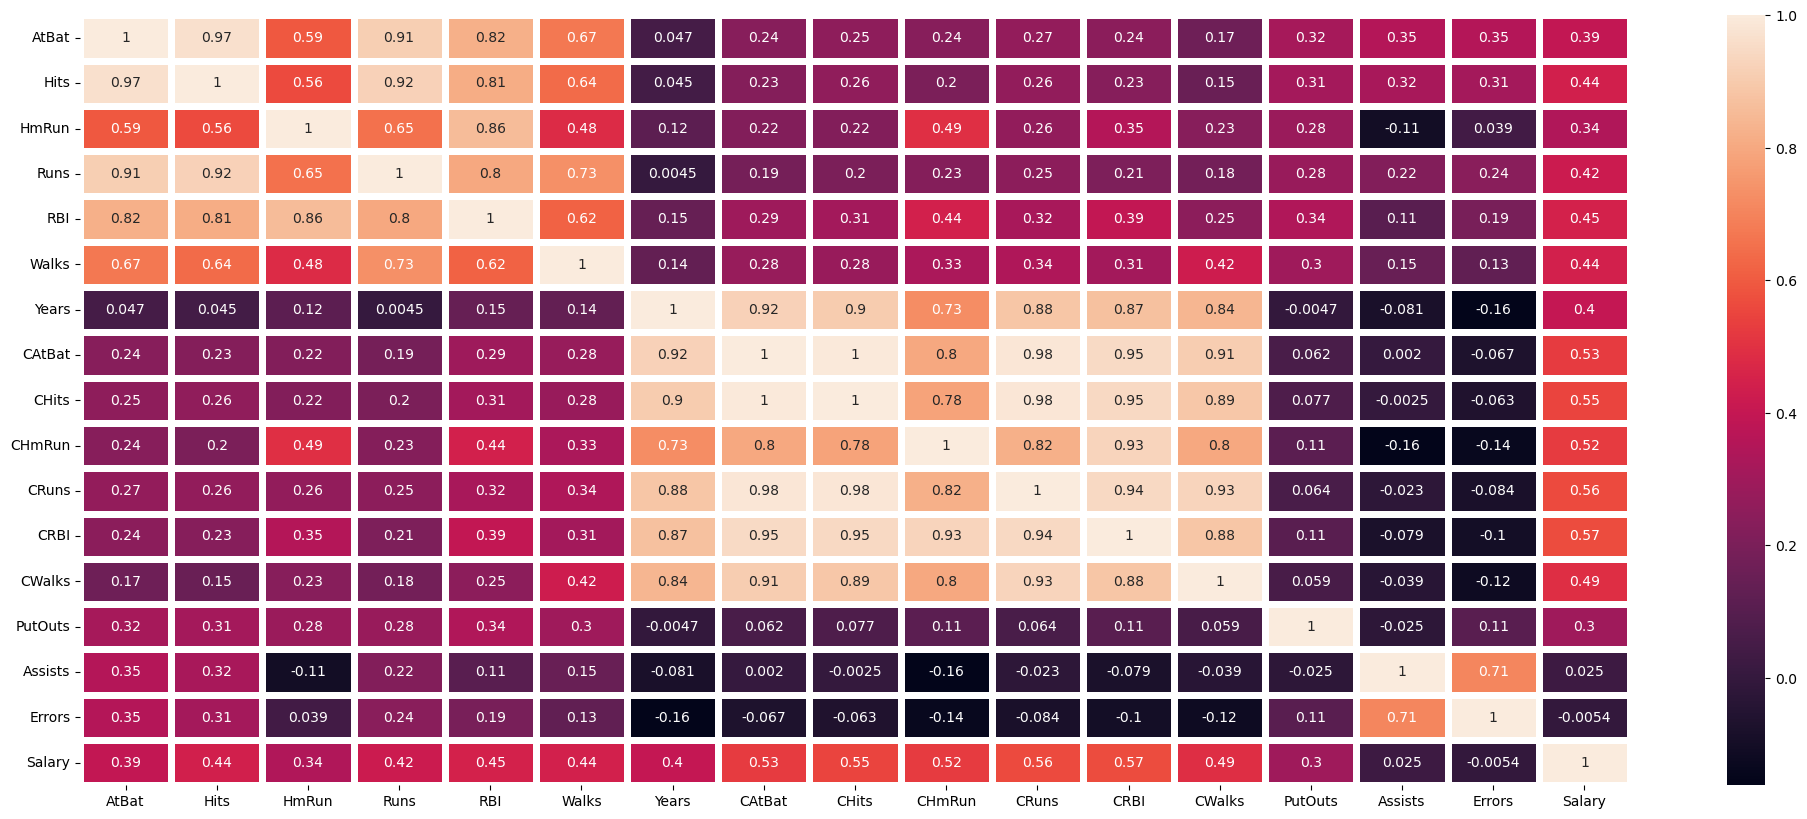

In [10]:
print(df[num_cols].corr(method="spearman"))

fig, ax = plt.subplots(figsize=(25,10))
sns.heatmap(df[num_cols].corr(),annot= True,linewidths=5, ax=ax)
plt.show()

In [18]:
def find_corelation(dataframe, numeric_cols, corr_limits= 0.50):
    high_corelation = []
    low_corelation = []
    for col in numeric_cols:
        if col == "Salary":
            pass
        else:
            corelation = dataframe[[col,"Salary"]].corr().loc[col,"Salary"]
            print(col,corelation)
            
            if abs(corelation) > corr_limits:
                high_corelation.append(col + " : " + str(corelation))
            else:
                low_corelation.append(col + " : " + str(corelation))
    return low_corelation , high_corelation

low_corrs , high_corrs = find_corelation(df,num_cols)
print("#################################################################")
print(low_corrs)
print("#################################################################")
print(high_corrs)


AtBat 0.39477094475973734
Hits 0.4386747378694112
HmRun 0.34302807815466363
Runs 0.4198585593019815
RBI 0.4494570879400337
Walks 0.44386726016297945
Years 0.40065699438268604
CAtBat 0.5261353096237892
CHits 0.5489095590351705
CHmRun 0.5249305595435935
CRuns 0.5626777110048051
CRBI 0.5669656856176524
CWalks 0.48982203628068005
PutOuts 0.30048035550600516
Assists 0.025436135647346703
Errors -0.005400701500953135
#################################################################
['AtBat : 0.39477094475973734', 'Hits : 0.4386747378694112', 'HmRun : 0.34302807815466363', 'Runs : 0.4198585593019815', 'RBI : 0.4494570879400337', 'Walks : 0.44386726016297945', 'Years : 0.40065699438268604', 'CWalks : 0.48982203628068005', 'PutOuts : 0.30048035550600516', 'Assists : 0.025436135647346703', 'Errors : -0.005400701500953135']
#################################################################
['CAtBat : 0.5261353096237892', 'CHits : 0.5489095590351705', 'CHmRun : 0.5249305595435935', 'CRuns : 0.562677

#### 6. Outliers (Aykırı Değerler)

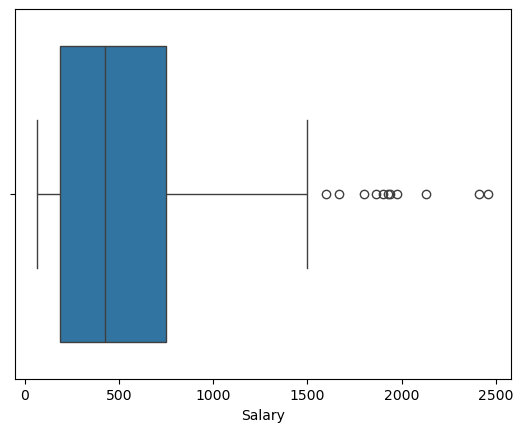

In [19]:
sns.boxplot(x=df["Salary"], data= df)
plt.show()

In [28]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):

    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    
    return low_limit, up_limit

def check_outliers(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
def replace_with_treshold(dataframe, veriable):
    low_limit, up_limit = outlier_thresholds(dataframe, veriable)
    dataframe.loc[dataframe[veriable] < low_limit, veriable] = low_limit
    dataframe.loc[dataframe[veriable] > up_limit, veriable] = up_limit
    
for col in num_cols:
    print(col, check_outliers(df, col)) 
print("#############################################")

for col in num_cols:
    if check_outliers(df, col):
        replace_with_treshold(df,col)


AtBat False
Hits False
HmRun True
Runs True
RBI True
Walks True
Years True
CAtBat True
CHits True
CHmRun True
CRuns True
CRBI True
CWalks True
PutOuts True
Assists True
Errors True
Salary True
#############################################


#### 7. Missing Values (Eksik Değerler)

In [29]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat(objs=[n_miss, np.round(ratio, decimals=2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

# Örnek kullanım
missing_values_table(df)


        n_miss  ratio
Salary      59 18.320


In [30]:
# Eksik veri analizine uygun olarak 3 farklı yöntem kullanılabilir.
df1 = df.copy()
df1.head()
cat_cols , num_cols, cat_but_car = grab_col_names(df1)


Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0
